# Grab Repository data      

In [1]:
from dotenv import load_dotenv
from helper.general import split_by_date, generate_value_in_buckets, truncate_to_same_length, aggregate_by_date, get_repository_paths
from helper.significance import check_normality_of_buckets, use_normality_results_for_significance_independent
import logging
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

load_dotenv(override=True)

True

In [2]:
REPO_PATHS = os.getenv('STORAGE_DIRECTORIES')
repository_directories = ast.literal_eval(REPO_PATHS) if REPO_PATHS else []
INTRO_DATE = os.getenv('INTRO_DATE')
START_DATE = os.getenv('START_DATE')
END_DATE = os.getenv('END_DATE')
BUCKET_SIZE = int(os.getenv('BUCKET_SIZE'))
RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")
storage_path = f'{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/commits_coupling_per_{BUCKET_SIZE}_days.csv'

# Get only first-level subfolders in the repository directories
repositories = get_repository_paths(repository_directories)

print(repositories)

['/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P3', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P9', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P2', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P8', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P1', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/k1bu0cscd4', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/5x4imrvk5b', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P7', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P5', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P14', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P6', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/bznd2hh7ii', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person

In [3]:
if INTRO_DATE == "":
    import json
    mapping_file = f"{repository_directories[0]}/mapping.json"
    # Check if the file exists
    if not os.path.exists(mapping_file):
        print(f"File not found: {mapping_file}. ")
    with open(mapping_file, 'r') as f:
        mapping = json.load(f)
    print(f"Using INTRO_DATE from mapping file: {INTRO_DATE}")

START_DATE = None
END_DATE = None


Using INTRO_DATE from mapping file: 


# Generate Commit Metrics per Repository

## Amount of Commits over time

In [4]:
import json

commit_result = []
for repository in repositories:
    if INTRO_DATE == "":
        person = repository.split('/')[-1]
        INTRO_DATE = mapping[person]['INTRO_DATE']
        START_DATE = mapping[person]['START_DATE']
        END_DATE = mapping[person]['END_DATE']
    commit_file = f"{repository}/commits.csv"
    # Check if the file exists
    if not os.path.exists(commit_file):
        print(f"File not found: {commit_file}. Skipping repository.")
        continue
    commit_df = pd.read_csv(commit_file)
    commit_df = commit_df[['sha', 'date']]
    ogs = commit_df.copy()
    commit_df = truncate_to_same_length(commit_df, INTRO_DATE, 'date', 'defined', START_DATE, END_DATE)
    min_date = commit_df["date"].min()
    # commit_df = aggregate_by_date(commit_df, 'date', 'sha', 'count')
    # print(commit_df['date'].max())

    pre_release, post_release = split_by_date(commit_df, INTRO_DATE, 'date')
    
    pre_shas = pre_release['sha'].values
    post_shas = post_release['sha'].values
    og_shas = ogs['sha'].values
    
    commit_files_file = f"{repository}/files.json"
    
    with open(commit_files_file, 'r') as f:
        files = json.load(f)

    if files is None or len(files) == 0:
        print(f"No commit files found in {commit_files_file}. Skipping repository.")
        continue    
    
    for commit in files:
        sha = commit["commit_sha"]
        files_changed = len(commit["commit_files"])
        
        if sha in pre_shas:
            pre_release.loc[pre_release['sha'] == sha, '#_changed_files'] = files_changed
        elif sha in post_shas:
            post_release.loc[post_release['sha'] == sha, '#_changed_files'] = files_changed
        else:
            if sha in og_shas:
                continue
            raise ValueError(f"Commit SHA {sha} not found in either pre-release or after-release buckets of {repository}.")

    pre_release_buckets = generate_value_in_buckets(pre_release, 'date', '#_changed_files', 'mean', BUCKET_SIZE, 'pre-')
    post_release_buckets = generate_value_in_buckets(post_release, 'date', '#_changed_files', 'mean', BUCKET_SIZE, 'post-')

    release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)
    repo_name = repository.split('/')[-1]
    
    result_row = {'repository': repo_name}
    result_row.update(release_buckets.set_index('bucket')['#_changed_files'].to_dict())  # Use 'count' instead of 'value'
    
    commit_result.append(result_row)

# Create the DataFrame
commit_result_df = pd.DataFrame(commit_result)


File not found: /Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants/commits.csv. Skipping repository.


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_92099/2061623394.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)


In [5]:
# Ensure the columns are in the correct order
def sort_buckets(df, prefix_one, prefix_two):
    order = ['repository']
    
    for prefix in [prefix_one, prefix_two]:
        counter = 0
        contained = True
        
        while contained:
            order.append(f'{prefix}{counter}')
            
            counter += 1
            if not f'{prefix}{counter}' in df:
                contained = False
        
    return order

columns_order = sort_buckets(commit_result_df, 'pre-', 'post-')
commit_result_df = commit_result_df[columns_order]

In [6]:
commit_result_df

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8
0,P3,1.758621,2.135135,2.244444,11.291667,2.789474,1.600000,9.947368,2.500000,71.500000,4.600000,32.000000,12.727273,8.615385,38.000000,NaN,12.000000,6.333333,5.000000
1,P9,1.719298,1.079208,0.714286,0.769231,1.612903,0.913043,1.304348,1.000000,1.361111,0.875000,9.242424,1.833333,2.375000,1.200000,NaN,0.822222,1.500000,1.411765
2,P2,1.400000,3.600000,2.333333,1.857143,3.363636,1.500000,NaN,17.250000,NaN,4.047619,2.421053,1.857143,3.100000,4.533333,1.000000,3.600000,3.666667,2.590909
3,P8,5.514286,7.722222,5.820513,6.000000,10.775000,8.769231,3.714286,2.428571,9.050000,3.762887,5.588235,2.833333,2.714286,2.421053,10.000000,5.458333,3.179487,4.945205
4,P1,5.116279,3.461538,1.448276,0.200000,0.200000,0.263158,0.375000,0.375000,0.200000,0.000000,0.300000,0.250000,0.000000,NaN,0.000000,NaN,0.300000,0.166667
5,k1bu0cscd4,2.000000,NaN,7.000000,NaN,9.500000,3.000000,NaN,NaN,NaN,2.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5x4imrvk5b,1.051282,6.428571,0.870968,0.923077,2.289474,1.069767,3.448980,1.725490,2.117647,1.448980,1.357143,2.032258,2.076923,2.833333,1.666667,2.388889,1.285714,1.000000
7,P7,3.500000,1.354839,0.594595,1.578947,8.000000,1.000000,5.000000,0.777778,NaN,1.000000,1.150000,2.034483,5.125000,2.750000,0.333333,0.666667,2.142857,3.750000
8,P5,9.750000,5.000000,7.500000,NaN,5.466667,6.000000,NaN,NaN,NaN,3.473684,5.058824,5.375000,4.562500,78.111111,0.000000,5.000000,24.400000,8.600000
9,P14,0.800000,17.982759,2.037736,5.285714,2.375000,3.000000,3.885714,4.093750,1.307692,1.910448,3.129032,2.214286,4.833333,3.100000,0.777778,2.656250,1.285714,0.694915


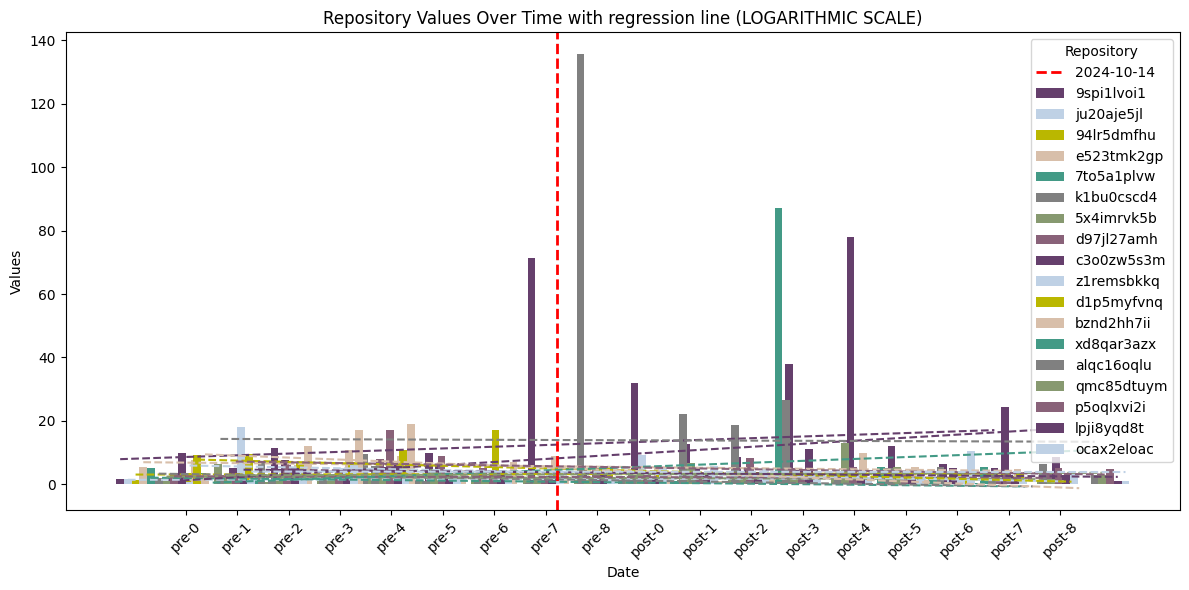

In [7]:
import numpy as np
from scipy.stats import linregress

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in commit_result_df.columns if col != 'repository']
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#D8BFAA", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(commit_result_df['repository']):
    # Extract data for the current repository
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    slope, intercept, _, _, _ = linregress(x, values.values)
    regression_line = slope * x + intercept
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='--', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = commit_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))  # Find the largest 'pre-x'
    post_0 = 'post-0' if 'post-0' in post_columns else None  # Ensure 'post-0' exists

    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2
        plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label=INTRO_DATE)

# Set x-axis ticks and labels
plt.xticks(x + (len(commit_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
# plt.yscale('log')
plt.show()

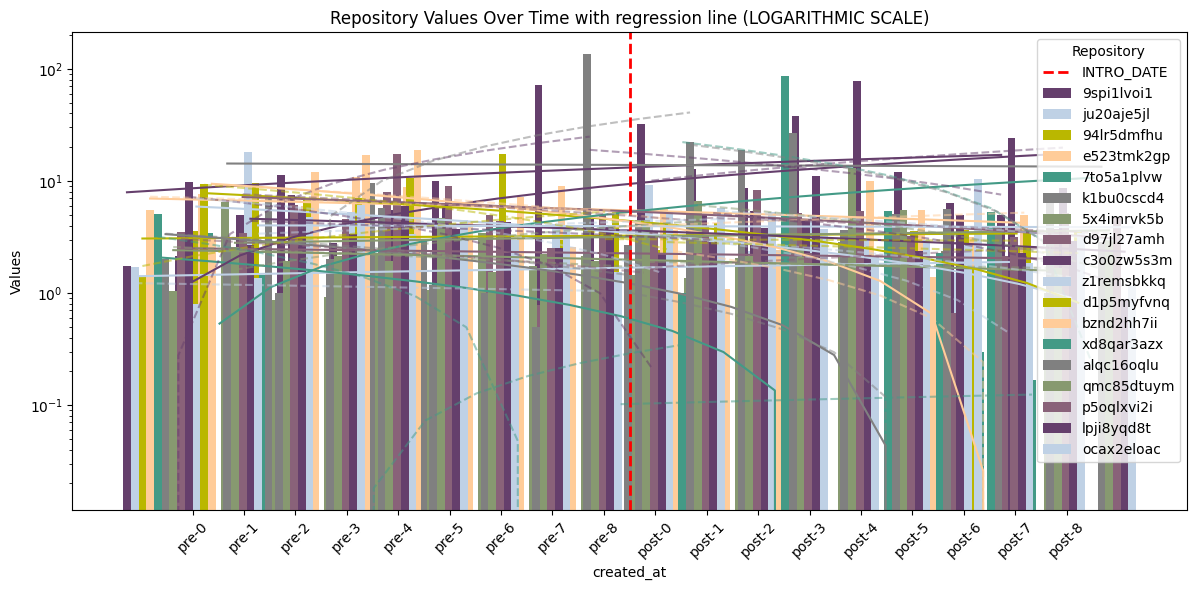

In [8]:
import numpy as np
from scipy.stats import linregress

tangent_data = []

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in commit_result_df.columns if col != 'repository']
colors = ["#FF4500", "#FFA500", "#FF8C00", "#FFD700", "#FF6347", "#FF7F50", "#FFB347", "#FFCC99"]
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#FFCC99", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(commit_result_df['repository']):
    # Extract data for the current repository
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    m, b, _, _, _ = linregress(x, values.values)
    regression_line = m * x + b
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='-', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = commit_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))
    post_0 = 'post-0' if 'post-0' in post_columns else None
    
    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2

        # Vertical red line at midpoint
        plt.axvline(x=midpoint + (len(commit_result_df['repository']) - 1) * bar_width / 2,
                    color='red', linestyle='--', linewidth=2, label="INTRO_DATE")

# Plot bars and regression lines
for i, repo in enumerate(commit_result_df['repository']):
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)

    offset_x = x + i * bar_width
    plt.bar(offset_x, values.values, bar_width, label="_nolegend_", color=colors[i % len(colors)])

    if pre_columns and post_columns and largest_pre and post_0:
        # Indices for regression segments
        pre_range = np.arange(0, post_0_index + 1)
        post_range = np.arange(post_0_index, len(values))

        # Extract values
        pre_values = values.values[pre_range]
        post_values = values.values[post_range]

        # Regression before midpoint
        m_pre, b_pre, *_ = linregress(pre_range, pre_values)
        reg_line_pre = m_pre * pre_range + b_pre
        plt.plot(offset_x[pre_range], reg_line_pre, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Regression after midpoint
        m_post, b_post, *_ = linregress(post_range, post_values)
        reg_line_post = m_post * post_range + b_post
        plt.plot(offset_x[post_range], reg_line_post, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Collect regression parameters
        tangent_data.append({
            'repository': repo,
            'm_pre': m_pre,
            'b_pre': b_pre,
            'm_post': m_post,
            'b_post': b_post
        })




# Set x-axis ticks and labels
plt.xticks(x + (len(commit_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('created_at')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
plt.show()

P3


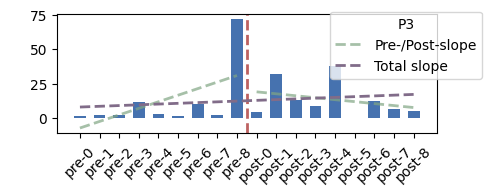

P4


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_92099/87908951.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=mapping[repo]['SYNONYM'], loc='center left', bbox_to_anchor=(0.89, 0.88))


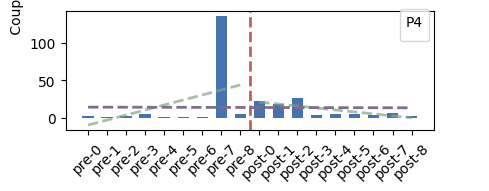

In [18]:
def compute_slope(row, cols):
    y = row[cols].values.astype(float)
    x = np.arange(len(y))
    
    # Remove NaN values from both x and y
    valid_indices = ~np.isnan(y)
    x = x[valid_indices]
    y = y[valid_indices]
    
    # Check if there are enough points to calculate a slope
    if len(y) < 2:
        return np.nan  # Not enough data points to calculate a slope
    
    return np.polyfit(x, y, 1)[0]

for i, repo in enumerate(commit_result_df['repository']):
    if mapping[repo]['SYNONYM'] not in ['P3', 'P4']:
        continue
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    print(repo)
    plt.figure(figsize=(5, 2))
    offset_x = x + i * bar_width
    plt.bar(offset_x, values.values, 0.6, color='#4672AF')
    plt.rcParams.update({'font.size': 10})
    # Find pre and post columns
    pre_columns = [col for col in date_columns if col.startswith('pre-')]
    post_columns = [col for col in date_columns if col.startswith('post-')]
    largest_pre = max(pre_columns, key=lambda c: int(c.split('-')[1])) if pre_columns else None
    post_0 = 'post-0' if 'post-0' in post_columns else None

    if largest_pre and post_0:
        pre_index = date_columns.index(largest_pre)
        post_0_index = date_columns.index(post_0)
        midpoint = (pre_index + post_0_index) / 2
        plt.axvline(x=midpoint + i * bar_width, color='#BD6261', linestyle='--', linewidth=2)

        # Pre and post ranges
        pre_range = np.arange(0, post_0_index + 1)
        post_range = np.arange(post_0_index, len(values))

        # Pre and post regression using compute_slope
        # Pre and post ranges
        pre_cols = date_columns[0:post_0_index]
        post_cols = date_columns[post_0_index:]

        # For regression lines, use np.polyfit to get both slope and intercept
        if len(pre_cols) > 1:
            m_pre = compute_slope(values, pre_cols)
            b_pre = np.polyfit(np.arange(len(pre_cols)), values[pre_cols].values, 1)[1]
            reg_line_pre = m_pre * np.arange(len(pre_cols)) + b_pre
            
            if mapping[repo]['SYNONYM'] == 'P3':
                plt.plot(offset_x[:len(pre_cols)], reg_line_pre, linestyle='--', linewidth=2, color='#81A684', alpha=0.7, label="Pre-/Post-slope")
            else:
                plt.plot(offset_x[:len(pre_cols)], reg_line_pre, linestyle='--', linewidth=2, color='#81A684', alpha=0.7, label="")
        if len(post_cols) > 1:
            m_post = compute_slope(values, post_cols)
            b_post = np.polyfit(np.arange(len(post_cols)), values[post_cols].values, 1)[1]
            reg_line_post = m_post * np.arange(len(post_cols)) + b_post
            plt.plot(offset_x[post_0_index:post_0_index+len(post_cols)], reg_line_post, linestyle='--', linewidth=2, color='#81A684', alpha=0.7, label="")

    # Overall regression (dashed, black) using compute_slope
    m_total = compute_slope(values, date_columns)
    if not np.isnan(m_total):
        b_total = np.polyfit(np.arange(len(date_columns)), values[date_columns].values, 1)[1]
        regression_line = m_total * np.arange(len(date_columns)) + b_total
        
        if mapping[repo]['SYNONYM'] == 'P3':
            plt.plot(offset_x, regression_line, color='#816C89', linestyle='--', linewidth=2, label="Total slope")
        else:
            plt.plot(offset_x, regression_line, color='#816C89', linestyle='--', linewidth=2, label="")

    plt.xticks(offset_x, date_columns, rotation=45)
    plt.title('')
    plt.xlabel('')
    if mapping[repo]['SYNONYM'] == 'P4':
        plt.ylabel('                         Coup')
    else:
        plt.ylabel('Coup', color='white')
    
    if mapping[repo]['SYNONYM'] == 'P3':
        plt.legend(title=mapping[repo]['SYNONYM'], loc='center left', bbox_to_anchor=(0.7, 0.74))
    else:
        if mapping[repo]['SYNONYM'] == 'P5':
            plt.legend(title=mapping[repo]['SYNONYM'], loc='center left', bbox_to_anchor=(0.88, 0.88))
            plt.text(19.45, 14.8, '  slope', fontdict={'fontsize': 10, 'color': 'white'})
        else:
            plt.legend(title=mapping[repo]['SYNONYM'], loc='center left', bbox_to_anchor=(0.89, 0.88))
            plt.text(20.15, 14.8, '  slope', fontdict={'fontsize': 10, 'color': 'white'})
        # plt.legend(title=mapping[repo]['SYNONYM'], loc='center left',bbox_to_anchor=(0.7, 0.74, 1.25, 1.25))  # width set, height auto
    plt.tight_layout()
    
    if mapping[repo]['SYNONYM'] in ['P3', 'P4']:
        save_dir = os.path.dirname(storage_path)
        pdf_path = f"{save_dir}/{mapping[repo]['SYNONYM']}_reversed.pdf"
        plt.savefig(pdf_path)
    
    # plt.yscale('log')
    plt.show()

# Significancetest 

In [10]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Replace NaN values with 0 in the commit_result_df
commit_result_df = commit_result_df.fillna(0)

# Columns for pre and after buckets
pre_columns = [col for col in commit_result_df.columns if col.startswith("pre-")]
after_columns = [col for col in commit_result_df.columns if col.startswith("post-")]

normality_results = check_normality_of_buckets(commit_result_df, pre_columns, after_columns)

# Display the results
print(normality_results)

    repository   pre_p_value  after_p_value  pre_normal  after_normal
0   P3  8.243368e-06   3.478554e-02       False         False
1   P9  6.237836e-01   2.121111e-04        True         False
2   P2  1.432330e-04   9.337834e-01       False          True
3   P8  9.298350e-01   3.438231e-02        True         False
4   P1  1.091910e-03   4.214088e-03       False         False
5   k1bu0cscd4  4.276514e-03   3.217493e-07       False         False
6   5x4imrvk5b  8.392412e-03   7.961169e-01       False          True
7   P7  4.304094e-02   4.548392e-01       False          True
8   P5  6.146246e-02   7.287650e-05        True         False
9   P14  3.771707e-04   6.239616e-01       False          True
10  P6  4.216674e-01   4.735236e-01        True          True
11  bznd2hh7ii  1.558648e-01   1.050970e-02        True         False
12  xd8qar3azx  1.000000e+00   1.766493e-06        True         False
13  P4  8.333791e-07   1.098309e-02       False         False
14  P13  4.883928e-03   6.451

/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [11]:
# significance_results_df = use_normality_results_for_significance_independent(normality_results, commit_result_df, pre_columns, after_columns)

# # Display the results
# print(significance_results_df)

from helper.significance import calculate_cliffs_delta_with_confidence
significance_results_df = calculate_cliffs_delta_with_confidence(commit_result_df, pre_columns, after_columns)

# Display the results
print(significance_results_df)

    repository      test_used  effect_size  ci_lower  ci_upper
0   P3  Cliff's Delta     0.382716 -0.160494  0.901235
1   P9  Cliff's Delta     0.234568 -0.358025  0.729012
2   P2  Cliff's Delta     0.382716 -0.148457  0.864506
3   P8  Cliff's Delta    -0.506173 -0.975309 -0.012346
4   P1  Cliff's Delta    -0.728395 -1.000000 -0.308642
5   k1bu0cscd4  Cliff's Delta    -0.358025 -0.753704  0.012346
6   5x4imrvk5b  Cliff's Delta     0.037037 -0.555556  0.580247
7   P7  Cliff's Delta     0.074074 -0.456790  0.629630
8   P5  Cliff's Delta     0.246914 -0.320988  0.753704
9   P14  Cliff's Delta    -0.333333 -0.753086  0.259259
10  P6  Cliff's Delta    -0.506173 -1.000000  0.087037
11  bznd2hh7ii  Cliff's Delta    -0.629630 -1.000000 -0.160185
12  xd8qar3azx  Cliff's Delta     0.555556  0.222222  0.888889
13  P4  Cliff's Delta     0.555556  0.037037  0.975309
14  P13  Cliff's Delta     0.111111 -0.457407  0.654321
15  P12  Cliff's Delta    -0.283951 -0.777778  0.259259
16  P10  Cliff's Delta

In [12]:
merged = commit_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,1.758621,2.135135,2.244444,11.291667,2.789474,1.600000,9.947368,2.500000,71.500000,...,8.615385,38.000000,0.000000,12.000000,6.333333,5.000000,Cliff's Delta,0.382716,-0.160494,0.901235
1,P9,1.719298,1.079208,0.714286,0.769231,1.612903,0.913043,1.304348,1.000000,1.361111,...,2.375000,1.200000,0.000000,0.822222,1.500000,1.411765,Cliff's Delta,0.234568,-0.358025,0.729012
2,P2,1.400000,3.600000,2.333333,1.857143,3.363636,1.500000,0.000000,17.250000,0.000000,...,3.100000,4.533333,1.000000,3.600000,3.666667,2.590909,Cliff's Delta,0.382716,-0.148457,0.864506
3,P8,5.514286,7.722222,5.820513,6.000000,10.775000,8.769231,3.714286,2.428571,9.050000,...,2.714286,2.421053,10.000000,5.458333,3.179487,4.945205,Cliff's Delta,-0.506173,-0.975309,-0.012346
4,P1,5.116279,3.461538,1.448276,0.200000,0.200000,0.263158,0.375000,0.375000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.300000,0.166667,Cliff's Delta,-0.728395,-1.000000,-0.308642
5,k1bu0cscd4,2.000000,0.000000,7.000000,0.000000,9.500000,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Cliff's Delta,-0.358025,-0.753704,0.012346
6,5x4imrvk5b,1.051282,6.428571,0.870968,0.923077,2.289474,1.069767,3.448980,1.725490,2.117647,...,2.076923,2.833333,1.666667,2.388889,1.285714,1.000000,Cliff's Delta,0.037037,-0.555556,0.580247
7,P7,3.500000,1.354839,0.594595,1.578947,8.000000,1.000000,5.000000,0.777778,0.000000,...,5.125000,2.750000,0.333333,0.666667,2.142857,3.750000,Cliff's Delta,0.074074,-0.456790,0.629630
8,P5,9.750000,5.000000,7.500000,0.000000,5.466667,6.000000,0.000000,0.000000,0.000000,...,4.562500,78.111111,0.000000,5.000000,24.400000,8.600000,Cliff's Delta,0.246914,-0.320988,0.753704
9,P14,0.800000,17.982759,2.037736,5.285714,2.375000,3.000000,3.885714,4.093750,1.307692,...,4.833333,3.100000,0.777778,2.656250,1.285714,0.694915,Cliff's Delta,-0.333333,-0.753086,0.259259


In [13]:
merged = commit_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,1.758621,2.135135,2.244444,11.291667,2.789474,1.600000,9.947368,2.500000,71.500000,...,8.615385,38.000000,0.000000,12.000000,6.333333,5.000000,Cliff's Delta,0.382716,-0.160494,0.901235
1,P9,1.719298,1.079208,0.714286,0.769231,1.612903,0.913043,1.304348,1.000000,1.361111,...,2.375000,1.200000,0.000000,0.822222,1.500000,1.411765,Cliff's Delta,0.234568,-0.358025,0.729012
2,P2,1.400000,3.600000,2.333333,1.857143,3.363636,1.500000,0.000000,17.250000,0.000000,...,3.100000,4.533333,1.000000,3.600000,3.666667,2.590909,Cliff's Delta,0.382716,-0.148457,0.864506
3,P8,5.514286,7.722222,5.820513,6.000000,10.775000,8.769231,3.714286,2.428571,9.050000,...,2.714286,2.421053,10.000000,5.458333,3.179487,4.945205,Cliff's Delta,-0.506173,-0.975309,-0.012346
4,P1,5.116279,3.461538,1.448276,0.200000,0.200000,0.263158,0.375000,0.375000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.300000,0.166667,Cliff's Delta,-0.728395,-1.000000,-0.308642
5,k1bu0cscd4,2.000000,0.000000,7.000000,0.000000,9.500000,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Cliff's Delta,-0.358025,-0.753704,0.012346
6,5x4imrvk5b,1.051282,6.428571,0.870968,0.923077,2.289474,1.069767,3.448980,1.725490,2.117647,...,2.076923,2.833333,1.666667,2.388889,1.285714,1.000000,Cliff's Delta,0.037037,-0.555556,0.580247
7,P7,3.500000,1.354839,0.594595,1.578947,8.000000,1.000000,5.000000,0.777778,0.000000,...,5.125000,2.750000,0.333333,0.666667,2.142857,3.750000,Cliff's Delta,0.074074,-0.456790,0.629630
8,P5,9.750000,5.000000,7.500000,0.000000,5.466667,6.000000,0.000000,0.000000,0.000000,...,4.562500,78.111111,0.000000,5.000000,24.400000,8.600000,Cliff's Delta,0.246914,-0.320988,0.753704
9,P14,0.800000,17.982759,2.037736,5.285714,2.375000,3.000000,3.885714,4.093750,1.307692,...,4.833333,3.100000,0.777778,2.656250,1.285714,0.694915,Cliff's Delta,-0.333333,-0.753086,0.259259


# Interpretation
- 0 -> less commits after introduction
- react-native -> higher coupling after introduction